In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [35]:
import numpy as np
import _pickle as cPickle
import tensorflow as tf
import time
import os
from urllib.request import urlretrieve
import tarfile
import zipfile
import sys

In [3]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [4]:
def  plot_imagesplot_im(images, cls_true, cls_pred=None):
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [ ]:
def getProgressBar(accuracy):
    percentage = int(round((accuracy)*100))
    progress_bar_size = 30
    completed = int((progress_bar_size*int(percentage))/100)
    progress_bar = '=' * completed + '>' + '-' * (progress_bar_size - completed)
    return progress_bar, percentage

In [53]:
def _print_download_progress(count, block_size, total_size):
    pct_complete = float(count * block_size) / total_size
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()


def downloadDataSetIfNotPresent():
    main_directory = os.path.join(os.getcwd(), 'data')
    
    cifar_10_directory = os.path.join(main_directory, 'cifar-10-batches-py')
    if not os.path.exists(main_directory):
        os.makedirs(main_directory)

        url = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
        filename = url.split('/')[-1]
        zip_cifar_10 = os.path.join(main_directory, filename)
        file_path, _ = urlretrieve(url=url, filename=zip_cifar_10, reporthook=_print_download_progress)

        print()
        print("Download finished. Extracting files.")
        if file_path.endswith(".zip"):
            zipfile.ZipFile(file=file_path, mode="r").extractall(main_directory)
        elif file_path.endswith((".tar.gz", ".tgz")):
            tarfile.open(name=file_path, mode="r:gz").extractall(main_directory)
        print("Done.")
        os.remove(zip_cifar_10)

In [45]:
def unpickle(file_name):
    with open(file_name, 'rb') as fo:
        dict = cPickle.load(fo, encoding='latin1')
    return dict

In [46]:
def readCIFARData():
    x = None
    y = None
    downloadDataSetIfNotPresent()
    for batch_no in range(1,6,1):
        data_dict = unpickle("data/cifar-10-batches-py/data_batch_%d"%batch_no)
        if batch_no == 1:
            x = data_dict['data']
            y = data_dict['labels']
        else:
            x = np.append(x, data_dict['data'], axis=0)
            y = np.append(y, data_dict['labels'], axis=0)
    mu = np.mean(x, axis=0)
    mu = mu.reshape(1,-1)
    sigma = np.std(x, axis=0)
    sigma = sigma.reshape(1, -1)
    x = x - mu
    x = x / sigma
    return x, y

In [47]:
def weight_variable(shape):
    print(shape)
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(length):
    initial = tf.constant(0.1, shape=[length], dtype=tf.float32)
    return tf.Variable(initial)

In [48]:
def createConvulationalLayer(input_data, channel_count, filter_size, filter_count, max_pooling=True):
    shape = [filter_size, filter_size, channel_count, filter_count]
    weights = weight_variable(shape=shape)
    bias = bias_variable(length=filter_count)
    layer = tf.nn.conv2d(input=input_data,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    layer += bias
    if max_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
        layer = tf.layers.dropout(layer, rate=0.25)
    layer = tf.nn.relu(layer)
    return layer, weights

In [49]:
def createFlattenLayer(layer):
    layer_shape = layer.get_shape()
    # layer_shape is assumed to be in shape [number_of_images, image_height, image_width, channels]
    # The channels will be the number of fiter_count in the previous layer
    feature_count = layer_shape[1:4].num_elements()
    layer_shape[1:4].num_elements()
    flat_layer = tf.reshape(layer, [-1, feature_count])
    return flat_layer, feature_count

In [50]:
def createFullyConnectedLayer(input_data, input_feature_count, output_feature_count, apply_relu=False):
    weights = weight_variable(shape=[input_feature_count, output_feature_count])
    bias = bias_variable(length=output_feature_count)
    layer = tf.matmul(input_data, weights) + bias
    if apply_relu:
        layer = tf.nn.relu(layer)
    return layer

In [54]:
x_data, y_data_raw = readCIFARData()
y_labels = unpickle("data/cifar-10-batches-py/batches.meta")['label_names']

- Download progress: 100.0%
Download finished. Extracting files.
Done.


In [ ]:
n_samples = x_data.shape[0]
x_data = x_data.reshape([-1, image_depth, image_height, image_width])
x_data = x_data.transpose([0, 2, 3, 1])

category_count = len(y_labels)
y_data_labels = [y_labels[x] for x in y_data_raw]

In [ ]:
y_data = np.zeros((n_samples, category_count))
for i in range(n_samples):
    y_data[i][y_data_raw[i]] = 1

In [ ]:
x_train = x_data[:-10000]
y_train = y_data[:-10000]

x_test = x_data[40000:]
y_test = y_data[40000:]

In [12]:
image_depth = 3
image_height = 32
image_width = 32

image_shape = (image_height, image_width, image_depth)

In [14]:
filter_size_2 = 2
filter_size_3 = 3
filter_size_5 = 5
filter_count_32 = 32
filter_count_64 = 64
filter_count_128 = 128

fully_conn_layer_1_out_size = 128
fully_conn_layer_2_out_size = category_count

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(10, 32, 32, 3)


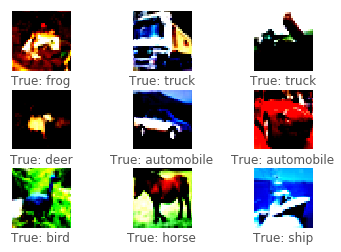

In [15]:
print(x_data[:10].shape)
plot_imagesplot_im(x_data[:10], y_data_labels[:10])

In [18]:
x = tf.placeholder(tf.float32, shape=[None, image_height, image_width, image_depth])
y_actual = tf.placeholder(tf.float32, shape=(None, category_count))

In [19]:
conv_layer_1, conv_weights_1 = createConvulationalLayer(input_data=x,
                   channel_count=image_depth,
                   filter_size=filter_size_3,
                   filter_count=filter_count_32,
                   max_pooling=False)

[3, 3, 3, 32]


In [20]:
conv_layer_2, conv_weights_2 = createConvulationalLayer(input_data=conv_layer_1,
                   channel_count=filter_count_32,
                   filter_size=filter_size_3,
                   filter_count=filter_count_64,
                   max_pooling=True)

[3, 3, 32, 64]


In [21]:
conv_layer_3, conv_weights_3 = createConvulationalLayer(input_data=conv_layer_2,
                   channel_count=filter_count_64,
                   filter_size=filter_size_3,
                   filter_count=filter_count_128,
                   max_pooling=False)

[3, 3, 64, 128]


In [22]:
conv_layer_4, conv_weights_4 = createConvulationalLayer(input_data=conv_layer_3,
                   channel_count=filter_count_128,
                   filter_size=filter_size_3,
                   filter_count=filter_count_128,
                   max_pooling=True)

[3, 3, 128, 128]


In [23]:
conv_layer_5, conv_weights_5 = createConvulationalLayer(input_data=conv_layer_4,
                   channel_count=filter_count_128,
                   filter_size=filter_size_3,
                   filter_count=filter_count_128,
                   max_pooling=False)

[3, 3, 128, 128]


In [24]:
flat_layer, num_features = createFlattenLayer(conv_layer_5)

In [25]:
fully_con_layer_1 = createFullyConnectedLayer(input_data=flat_layer,
                         input_feature_count=num_features,
                         output_feature_count=fully_conn_layer_1_out_size,
                         apply_relu=True)

[8192, 128]


In [26]:
fully_con_layer_2 = createFullyConnectedLayer(input_data=fully_con_layer_1,
                         input_feature_count=fully_conn_layer_1_out_size,
                         output_feature_count=fully_conn_layer_1_out_size,
                         apply_relu=True)

[128, 128]


In [27]:
fully_con_layer_3 = createFullyConnectedLayer(input_data=fully_con_layer_2,
                         input_feature_count=fully_conn_layer_1_out_size,
                         output_feature_count=fully_conn_layer_2_out_size,
                         apply_relu=False)

[128, 10]


In [28]:
y_predicted = tf.nn.softmax(fully_con_layer_3)
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_actual * tf.log(y_predicted), reduction_indices=[1]))
optimizer = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [29]:
is_correct = tf.equal(tf.argmax(y_predicted, 1), tf.argmax(y_actual, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

In [34]:
epochs = 100

session = tf.Session(config=tf.ConfigProto(log_device_placement=True))

init = tf.global_variables_initializer()
session.run(init)

start_time = time.time()

batch_size = 128
total_batches = int(x_train.shape[0] / batch_size)
print("Total batches are ", total_batches)
highest_test_accuracy = 0
highest_train_accuracy = 0
train_ac, test_ac = 0, 0
training_done = False
for i in range(epochs):
    if training_done:
        break
    print("Iteration [%d]"%i)
    for batch_no in range(total_batches):
        start_index = batch_no * batch_size
        end_index = (batch_no + 1) * batch_size
        batch_X = x_train[start_index:end_index]
        batch_Y  = y_train[start_index:end_index]

        train_data = {x: batch_X, y_actual: batch_Y}
        
        indices = np.random.choice(10000, 256)
        test_batch_X = x_train[indices]
        test_batch_Y  = y_train[indices]
        test_data = {x: test_batch_X, y_actual: test_batch_Y}

        # Training Step
        session.run(optimizer, feed_dict=train_data)
        
        end_time = time.time()
        # Calculate accuracy of the model on the training data in the current epoch
        train_ac = session.run(accuracy, feed_dict=train_data)
        test_ac = session.run(accuracy, feed_dict=test_data)
        
        if train_ac > highest_train_accuracy or test_ac > highest_test_accuracy:
            highest_train_accuracy = max(train_ac, highest_train_accuracy)
            highest_test_accuracy = max(test_ac, highest_test_accuracy)
            
            train_p_bar, train_percent = getProgressBar(highest_train_accuracy)
            test_p_bar, test_percent = getProgressBar(highest_test_accuracy)

            msg = "Iteration:{:>3} - [{}] {:>3}% -Train Acc | [{}] {:>3}% -Test Acc"
            print(msg.format(i, train_p_bar, train_percent, test_p_bar, test_percent))
            if highest_train_accuracy == 1.0:
                training_done = True
                break
            
    start_time = end_time
print("Training Done")

Total batches are  312
Iteration [0]
Iteration:  0 - [===>---------------------------]  12% -Train Acc | [==>----------------------------]   8% -Test Acc
Iteration:  0 - [===>---------------------------]  12% -Train Acc | [==>----------------------------]   9% -Test Acc
Iteration:  0 - [===>---------------------------]  13% -Train Acc | [===>---------------------------]  13% -Test Acc
Iteration:  0 - [===>---------------------------]  13% -Train Acc | [====>--------------------------]  14% -Test Acc
Iteration:  0 - [====>--------------------------]  15% -Train Acc | [====>--------------------------]  14% -Test Acc
Iteration:  0 - [====>--------------------------]  15% -Train Acc | [====>--------------------------]  15% -Test Acc
Iteration:  0 - [=====>-------------------------]  17% -Train Acc | [====>--------------------------]  15% -Test Acc
Iteration:  0 - [=====>-------------------------]  17% -Train Acc | [====>--------------------------]  15% -Test Acc
Iteration:  0 - [=====>----

Iteration:  6 - [=====================>---------]  71% -Train Acc | [=====================>---------]  72% -Test Acc
Iteration:  6 - [=====================>---------]  73% -Train Acc | [=====================>---------]  72% -Test Acc
Iteration [7]
Iteration:  7 - [======================>--------]  74% -Train Acc | [=====================>---------]  72% -Test Acc
Iteration:  7 - [======================>--------]  75% -Train Acc | [=====================>---------]  72% -Test Acc
Iteration:  7 - [======================>--------]  76% -Train Acc | [=====================>---------]  72% -Test Acc
Iteration:  7 - [======================>--------]  76% -Train Acc | [=====================>---------]  73% -Test Acc
Iteration [8]
Iteration:  8 - [======================>--------]  76% -Train Acc | [======================>--------]  75% -Test Acc
Iteration:  8 - [=======================>-------]  77% -Train Acc | [======================>--------]  75% -Test Acc
Iteration:  8 - [===================

In [58]:
saver = tf.train.Saver()
model = os.path.join(os.getcwd(), 'model')
if not os.path.exists(model):
    os.makedirs(model)
save_path = saver.save(session, os.path.join(model, "model.ckpt"))
print("Model saved in path: %s" % save_path)

Model saved in path: /home/amit/notebooks/model/model.ckpt
